## Are fitted distributions concordant across pathologies?
### Author: Deb Debnath

#### Data loading

In [1]:
import warnings
import logging
import ipywidgets as widgets
from dataclasses import dataclass, field
from typing import Optional, Sequence

logging.basicConfig(format="%(asctime)s-%(levelname)s: %(msg)s", level=logging.WARNING)

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot
from src.classifier import z_score, linear_classifier_score, linear_classifier_subscores, antilogit_classifier_score
from src.dist_fitting import (
        test_gamma_fit, 
        test_lognormal_fit_ks, 
        test_lognormal_fit_sw, 
        test_negative_binomial_fit, 
        test_poisson_fit, 
        test_zero_inflated_poisson_fit,
        test_zero_inflated_negative_binomial_fit
)
from src.random_sample import (
    sample_zero_inflated_poisson,
    sample_zero_inflated_negative_binomial,
    sample_poisson_mean_rsd,
    sample_zero_inflated_poisson_mean_rsd,
    sample_negative_binomial_mean_rsd,
    sample_zero_inflated_negative_binomial_mean_rsd,
    sample_gamma_mean_rsd,
    sample_lognormal_mean_rsd
)

In [4]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [5]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [6]:
mean_TPM = 0

In [7]:
num_patients = 243
n_samples = 1000
uncertainties = [10, 25, 50]

In [8]:
seed = 321

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [11]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [12]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_756485/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [13]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [14]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [15]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [16]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [17]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [18]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [19]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

## Goodness of fit criteria

### 1. Kolmogorov–Smirnov (KS) Test

The KS test measures the maximum distance between the empirical CDF of the data and the CDF of the fitted model. A high p-value suggests that the model is a good fit (i.e. there is no significant difference).

### 2. Anderson–Darling (AD) Test

The AD test is similar in spirit to the KS test but gives extra weight to the tails of the distribution. 

### 3. Akaike Information Criterion (AIC)

## Fitting discrete distributions to Gene data

In [20]:
warnings.filterwarnings("ignore")
def find_best_dist_aic(gene: str, results: pd.DataFrame) -> str:
    subset = results.loc[gene, ["poisson_aic", "nb_aic", "zip_aic", "zinb_aic"]]
    subset = subset.dropna()
    min_aic = subset.min()
    filt = (subset == min_aic)
    return subset[filt].index[0].split("_")[0].upper()

def find_best_dist_ks_p_value(gene: str, results: pd.DataFrame) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = results.loc[gene, ["poisson_p_val", "nb_p_val", "zip_p_val", "zinb_p_val"]]
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].split("_")[0].upper()

def fit_discrete_distributions_to_genes(tpm_df: pd.DataFrame, means: pd.Series, stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=tpm_df.index, columns=["vmr", "best_fit_aic", "best_fit_p_value",
                                                      "poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda", 
                                                      "nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p", 
                                                      "zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi",
                                                      "zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"])
    for i in range(tpm_df.shape[0]):
        gene = tpm_df.index[i]
        row = tpm_df.iloc[i, :]
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, ["poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda"]] = test_poisson_fit(row)
        res.loc[gene, ["zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi"]] = test_zero_inflated_poisson_fit(row)
        res.loc[gene, ["nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p"]] = test_negative_binomial_fit(row)
        res.loc[gene, ["zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"]] = test_zero_inflated_negative_binomial_fit(row)
        res.loc[gene, "best_fit_aic"] = find_best_dist_aic(gene, res)
        res.loc[gene, "best_fit_p_value"] = find_best_dist_ks_p_value(gene, res)
    return res

In [21]:
discrete_dist_fitting_results = fit_discrete_distributions_to_genes(patients_df, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion')

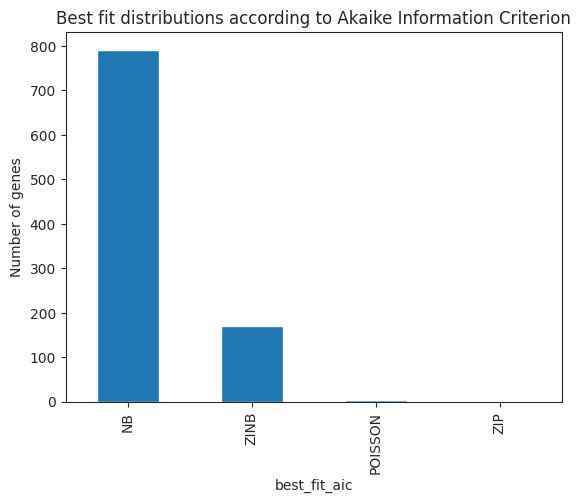

In [22]:
vc = discrete_dist_fitting_results["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic')

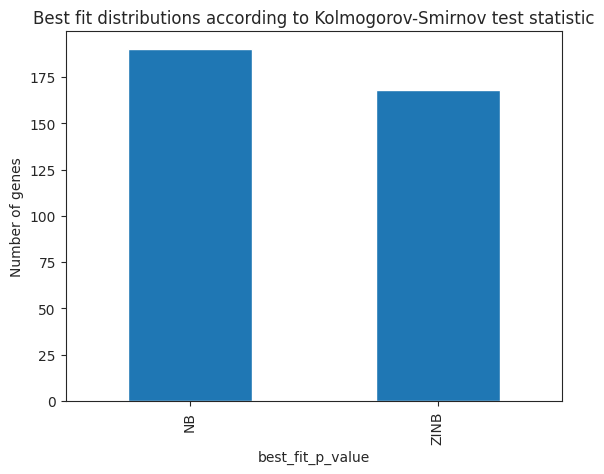

In [23]:
vc = discrete_dist_fitting_results["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic")

## Fitting continuous distributions to Gene data

In [24]:
def find_best_continuous_dist_p_value(gene: str, results: pd.DataFrame) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = results.loc[gene, ["gamma_ks_p_val", "lognormal_sw_p_val"]]
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].split("_")[0].upper()

def fit_continuous_distributions_to_genes(tpm_df: pd.DataFrame, means: pd.Series, stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=tpm_df.index, columns=["vmr", "best_fit", "best_fit_ad", "best_fit_nci",
                                                                 "gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta", 
                                                                 "lognormal_sw_stat", "lognormal_sw_p_val"])
    for i in range(tpm_df.shape[0]):
        gene = tpm_df.index[i]
        row = tpm_df.iloc[i, :]
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, ["gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta"]] = test_gamma_fit(row)
        res.loc[gene, ["lognormal_sw_stat", "lognormal_sw_p_val"]] = test_lognormal_fit_sw(row)
        res.loc[gene, "best_fit"] = find_best_continuous_dist_p_value(gene, res)
    return res

In [25]:
continuous_dist_fitting_results = fit_continuous_distributions_to_genes(patients_df, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

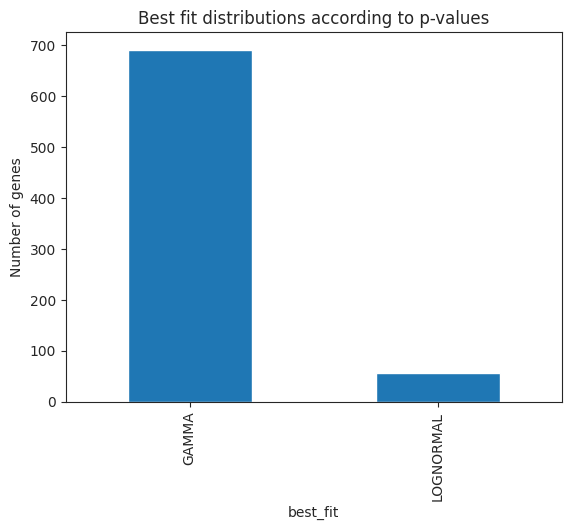

In [26]:
vc = continuous_dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

### Prep

In [27]:
nci_filt = (pathos == "NCI")

In [28]:
nci_subset = patients_df.loc[:, pathos[nci_filt.values].index]
ad_subset = patients_df.loc[:, pathos[~nci_filt.values].index]

### Discrete distributions

#### AD

In [29]:
discrete_dist_fitting_results_ad = fit_discrete_distributions_to_genes(ad_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion (AD subset)')

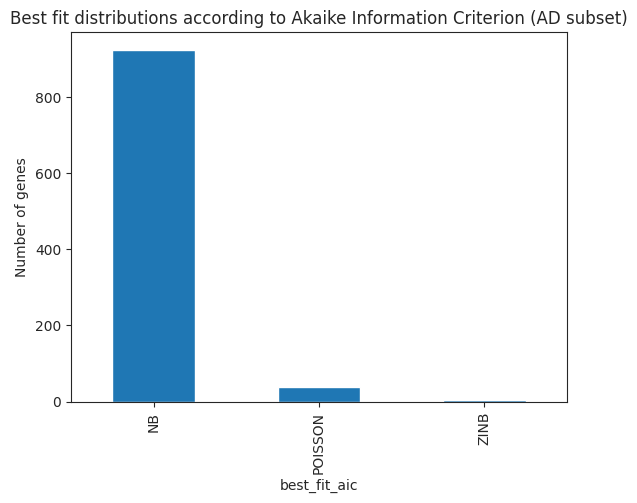

In [30]:
vc = discrete_dist_fitting_results_ad["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion (AD subset)")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic (AD subset)')

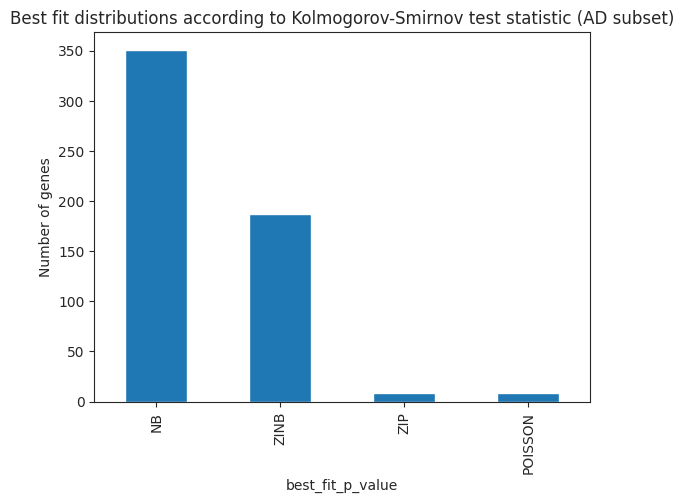

In [31]:
vc = discrete_dist_fitting_results_ad["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic (AD subset)")

#### NCI

In [32]:
discrete_dist_fitting_results_nci = fit_discrete_distributions_to_genes(nci_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion (NCI subset)')

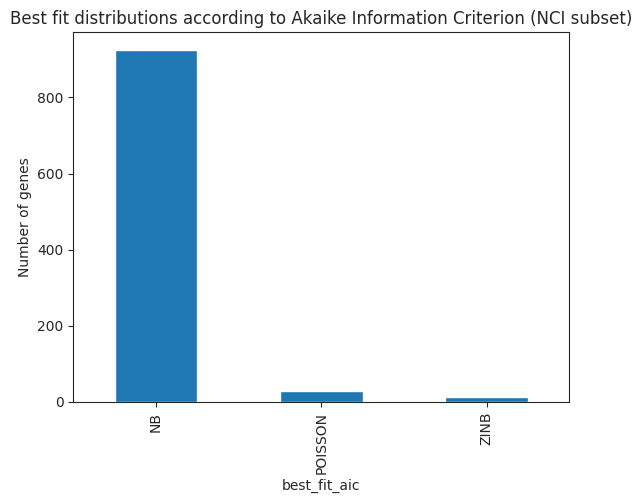

In [33]:
vc = discrete_dist_fitting_results_nci["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion (NCI subset)")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic (NCI subset)')

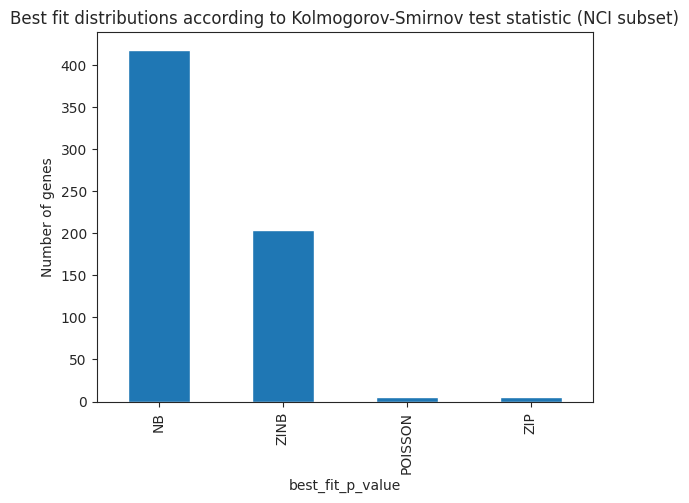

In [34]:
vc = discrete_dist_fitting_results_nci["best_fit_p_value"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic (NCI subset)")

#### Concordance between AD and NCI

In [35]:
discrete_dist_wise_concordance = pd.DataFrame(index=["poisson", "nb", "zip", "zinb"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in discrete_dist_wise_concordance.index:
    col = f"{dist}_p_val"
    ad_filt = (discrete_dist_fitting_results_ad[col] >= 0.05)
    nci_filt = (discrete_dist_fitting_results_nci[col] >= 0.05)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
poisson,8,58
nb,568,201
zip,8,59
zinb,388,324


In [36]:
discrete_dist_wise_concordance = pd.DataFrame(index=["POISSON", "NB", "ZIP", "ZINB"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["POISSON", "NB", "ZIP", "ZINB"]:
    ad_filt = (discrete_dist_fitting_results_ad["best_fit_aic"] == dist)
    nci_filt = (discrete_dist_fitting_results_nci["best_fit_aic"] == dist)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
POISSON,16,35
NB,903,44
ZIP,0,0
ZINB,1,15


In [37]:
discrete_dist_wise_concordance = pd.DataFrame(index=["POISSON", "NB", "ZIP", "ZINB"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["POISSON", "NB", "ZIP", "ZINB"]:
    ad_filt = discrete_dist_fitting_results_ad["best_fit_p_value"] == dist
    nci_filt = discrete_dist_fitting_results_nci["best_fit_p_value"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    discrete_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    discrete_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
discrete_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
POISSON,0,15
NB,213,343
ZIP,0,14
ZINB,54,283


### Continuous distributions

#### AD

In [38]:
continuous_dist_fitting_results_ad = pd.DataFrame(index=patients_df.index, columns=["vmr", "best_fit", "best_fit_ad", "best_fit_nci",
                                                                 "gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta", 
                                                                 "lognormal_sw_stat", "lognormal_sw_p_val"])

In [39]:
continuous_dist_fitting_results_ad = fit_continuous_distributions_to_genes(ad_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values (AD subset)')

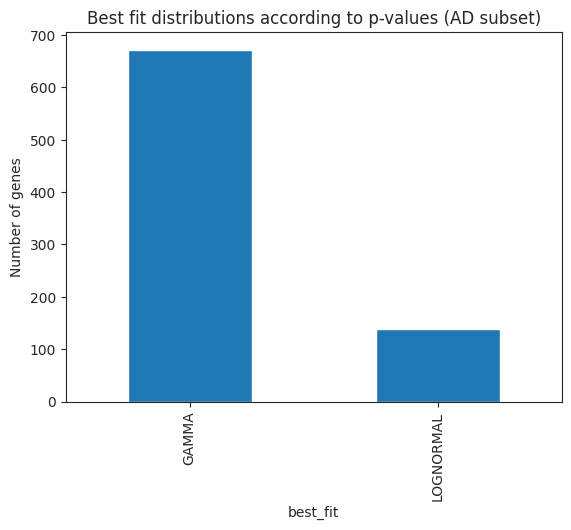

In [40]:
vc = continuous_dist_fitting_results_ad["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values (AD subset)")

<Axes: ylabel='ENSG00000079482.12'>

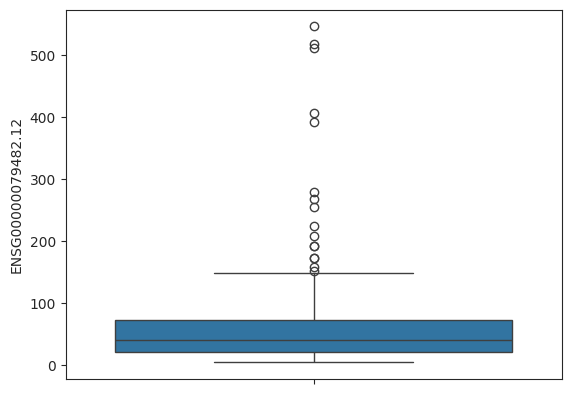

In [41]:
sns.boxplot(data=ad_subset.T, y=ad_subset.index[0])

<Axes: ylabel='ENSG00000079482.12'>

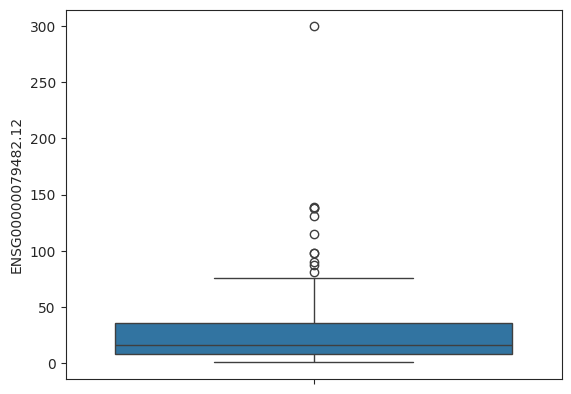

In [42]:
sns.boxplot(data=nci_subset.T, y=nci_subset.index[0])

#### NCI

In [43]:
continuous_dist_fitting_results_nci = fit_continuous_distributions_to_genes(nci_subset, means, stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values (NCI subset)')

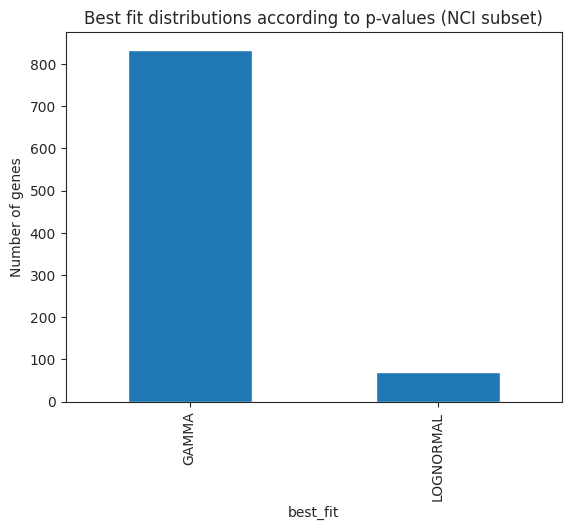

In [44]:
vc = continuous_dist_fitting_results_nci["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values (NCI subset)")

#### Concordance between AD and NCI

In [45]:
continuous_dist_wise_concordance = pd.DataFrame(index=["lognormal", "gamma"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in continuous_dist_wise_concordance.index:
    col = "lognormal_sw_p_val" if dist == "lognormal" else "gamma_ks_p_val"
    ad_filt = (continuous_dist_fitting_results_ad[col] >= 0.05)
    nci_filt = (continuous_dist_fitting_results_nci[col] >= 0.05)
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    continuous_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    continuous_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes)) 
continuous_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
lognormal,125,414
gamma,797,154


In [46]:
continuous_dist_wise_concordance = pd.DataFrame(index=["LOGNORMAL", "GAMMA"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in ["LOGNORMAL", "GAMMA"]:
    ad_filt = continuous_dist_fitting_results_ad["best_fit"] == dist
    nci_filt = continuous_dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    continuous_dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    continuous_dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes)) 
continuous_dist_wise_concordance

,Number of concordant genes,Number of discordant genes
LOGNORMAL,18,173
GAMMA,609,288


### Checking for concordance by considering only Negative binomial, lognormal and gamma distributions

For comparing between the three, distribution-specific goodness of fit metrics are used - 
- p-value for the KS test for negative binomial and gamma distributions
- p-value for the Shapiro-Wilk test for the lognormal distribution.

#### Overall

In [47]:
def _find_best_dist(lognormal_sw_p_val: Optional[float], gamma_ks_p_val: Optional[float], nb_ks_p_val: Optional[float]) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = pd.Series(index=["lognormal", "negative binomial", "gamma"], data=[lognormal_sw_p_val, gamma_ks_p_val, nb_ks_p_val])
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].upper()


def find_best_fit_dist(*, 
                       lognormal_sw_p_vals: pd.Series, 
                       gamma_ks_p_vals: pd.Series,
                       nb_ks_p_vals: pd.Series,
                       means: pd.Series, 
                       stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=lognormal_sw_p_vals.index, columns=["vmr", "best_fit", "gamma_ks_p_val", "lognormal_sw_p_val", "nb_ks_p_val"])
    for gene in res.index:
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, "best_fit"] = _find_best_dist(lognormal_sw_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene])
        res.loc[gene, ["lognormal_sw_p_val", "gamma_ks_p_val", "nb_ks_p_val"]] = lognormal_sw_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene]
    return res

In [48]:
dist_fitting_results = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results["nb_p_val"], 
                                            means=means, stds=stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

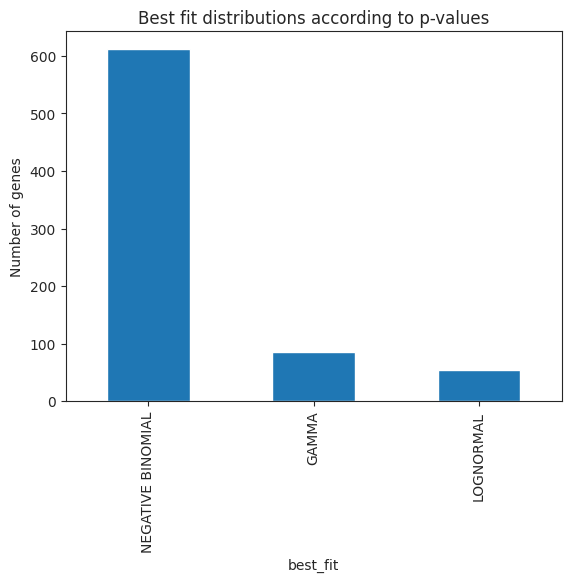

In [49]:
vc = dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

#### AD and NCI

In [50]:
dist_fitting_results_ad = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results_ad["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results_ad["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results_ad["nb_p_val"], 
                                            means=means, stds=stds)

In [51]:
dist_fitting_results_nci = find_best_fit_dist(lognormal_sw_p_vals=continuous_dist_fitting_results_nci["lognormal_sw_p_val"],
                                            gamma_ks_p_vals=continuous_dist_fitting_results_nci["gamma_ks_p_val"],
                                            nb_ks_p_vals=discrete_dist_fitting_results_nci["nb_p_val"], 
                                            means=means, stds=stds)

In [52]:
vc = dist_fitting_results["best_fit"].value_counts()
vc_ad = dist_fitting_results_ad["best_fit"].value_counts()
vc_nci = dist_fitting_results_nci["best_fit"].value_counts()

In [53]:
width = 0.3

Text(0.5, 1.0, 'Best fit distributions according to p-values')

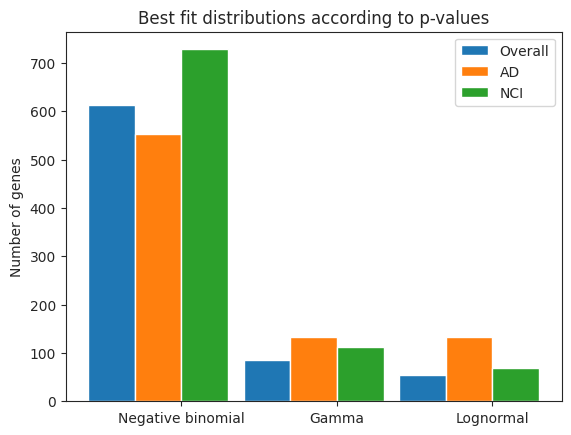

In [54]:
plt.bar(np.arange(3), vc, width, label="Overall")
plt.bar(np.arange(3)+width, vc_ad, width, label="AD")
plt.bar(np.arange(3)+2*width, vc_nci, width, label="NCI")
plt.xticks(np.arange(3)+1.5*width, ["Negative binomial", "Gamma", "Lognormal"])
plt.ylabel("Number of genes")
plt.legend()
plt.title("Best fit distributions according to p-values")

In [55]:
dist_wise_concordance = pd.DataFrame(index=["NEGATIVE BINOMIAL", "GAMMA", "LOGNORMAL"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in dist_wise_concordance.index:
    ad_filt = dist_fitting_results_ad["best_fit"] == dist
    nci_filt = dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
dist_wise_concordance

,Number of concordant genes,Number of discordant genes
NEGATIVE BINOMIAL,473,335
GAMMA,43,158
LOGNORMAL,17,167


In [56]:
print(dist_fitting_results["best_fit"].isna().sum(), dist_fitting_results_ad["best_fit"].isna().sum(), dist_fitting_results_nci["best_fit"].isna().sum())

216 149 59


## Sampling from Best Fit Distributions (Subject level)

### Testing

In [57]:
i, j = np.random.randint(0, patients_df.shape[0]), np.random.randint(0, patients_df.shape[1])

In [58]:
def plot_boxplot_gene_samples(patients_df: pd.DataFrame, best_fit_dists: pd.Series, uncertainty: int, n_samples: int, i: int, j: int):
    gene = patients_df.index[i]
    mean = patients_df.iloc[i, j]
    mean_gene = np.mean(patients_df.iloc[i, :])
    samples_gene = None
    gene_best_fit = best_fit_dists[gene]

    if gene_best_fit is None:
        gene_best_fit = "NEGATIVE BINOMIAL"
    if gene_best_fit == "NEGATIVE BINOMIAL" and (uncertainty / 100) ** 2.0 <= 1/mean_gene:
        gene_best_fit = "LOGNORMAL"

    match gene_best_fit:
        case "NEGATIVE BINOMIAL":
            samples_gene = sample_negative_binomial_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
        case "LOGNORMAL":
            samples_gene = sample_lognormal_mean_rsd(mean_gene, uncertainty / 100.0, n_samples)
        case "GAMMA":
            samples_gene = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)

    # Sample from distribution
    if (uncertainty / 100) ** 2.0 > 1/mean:
        samples_nb = sample_negative_binomial_mean_rsd(mean, uncertainty / 100.0, n_samples)
    else:
        samples_nb = None
    samples_ln = sample_lognormal_mean_rsd(mean, uncertainty / 100.0, n_samples)
    samples_g = sample_gamma_mean_rsd(mean, uncertainty / 100.0, n_samples)

    # Plot boxplots of genes
    data, labels = [samples_gene, samples_ln, samples_g], ["gene", "lognormal", "gamma"]
    if samples_nb is not None:
        data.append(samples_nb)
        labels.append("negative binomial")
    plt.boxplot(data)
    plt.xticks(list(range(1, len(labels)+1)), labels)
    plt.ylabel("Simulated TPM counts")
    plt.title(f"{gene=},\nmean = {mean:.2f}, uncertainty = {uncertainty}%")

In [59]:
def plot_sampled_data_for_gene_and_patient(i: int, j: int) -> None:
    fig = plt.figure(figsize=(18, 6))
    fig.add_subplot(131)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 10, n_samples, i, j)
    fig.add_subplot(132)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 25, n_samples, i, j)
    fig.add_subplot(133)
    plot_boxplot_gene_samples(patients_df, dist_fitting_results["best_fit"], 50, n_samples, i, j)

In [60]:
i_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
j_slider = widgets.IntSlider(min=0, max=patients_df.shape[1]-1, step=1, value=0, description='Patient index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
widgets.interactive(plot_sampled_data_for_gene_and_patient, i=i_slider, j=j_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Gene index:', max=966), IntSlid…